In [1]:
import warnings; warnings.filterwarnings("ignore")

# Import data

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(10000, 28 * 28)

Using TensorFlow backend.


In [3]:
print(list(X_train[7, :]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 43, 105, 255, 253, 253, 253, 253, 253, 174, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 139, 224, 226, 252, 253, 252, 252, 252, 252, 252, 252, 158, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 178, 252, 252, 252, 252, 253, 252, 252, 252, 252, 252, 252, 252, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 109, 252, 252, 230, 132, 133, 132, 132, 189, 252, 252, 252, 252, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 29, 29, 24, 0, 0, 0, 0, 14, 226, 252, 252, 172, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

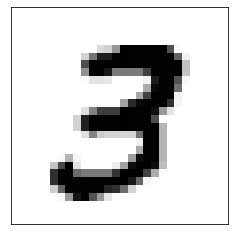

In [4]:
import matplotlib.pyplot as plt

plt.imshow(X_train[7, :].reshape(28, 28), cmap = 'binary', vmin = 0, vmax = 255)
plt.xticks([])
plt.yticks([])
plt.savefig('sample_image.png')

# Feature selection

### 1. F-statistic

In [5]:
from sklearn.feature_selection import f_classif

f = f_classif(X_train, y_train)[0]

### 2. Mutual information

In [6]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train)

### 3. Logistic regression

In [7]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)

### 4. LightGBM

In [8]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    objective = 'multiclass',
    metric = 'multi_logloss',
    importance_type = 'gain'
).fit(X_train, y_train)

### 5. Boruta

In [9]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

boruta = BorutaPy(
    estimator = RandomForestClassifier(max_depth = 5), 
    n_estimators = 'auto', 
    max_iter = 100
).fit(X_train, y_train)

### 6. MRMR

In [10]:
import pandas as pd
from mrmr import mrmr_classif

mrmr = mrmr_classif(pd.DataFrame(X_train), pd.Series(y_train), K = 784)

### Store results

In [11]:
import numpy as np

ranking = pd.DataFrame(index = range(X_train.shape[1]))

ranking['f'] = pd.Series(f, index = ranking.index).fillna(0).rank(ascending = False)
ranking['mi'] = pd.Series(mi, index = ranking.index).fillna(0).rank(ascending = False)
ranking['logreg'] = pd.Series(np.abs(logreg.coef_).mean(axis = 0), index = ranking.index).rank(ascending = False)
ranking['lightgbm'] = pd.Series(lgbm.feature_importances_, index = ranking.index).rank(ascending = False)
ranking['boruta'] = boruta.support_* 1 + boruta.support_weak_ * 2 + (1 - boruta.support_ - boruta.support_weak_) * X_train.shape[1]
ranking['mrmr'] = pd.Series(list(range(1, len(mrmr) + 1)) + [X_train.shape[1]] * (X_train.shape[1] - len(mrmr)), index = mrmr + list(set(ranking.index) - set(mrmr))).sort_index()

ranking = ranking.replace(to_replace = ranking.max(), value = X_train.shape[1])
ranking.to_csv('ranking.csv', index = False)

# Plot Feature Importances

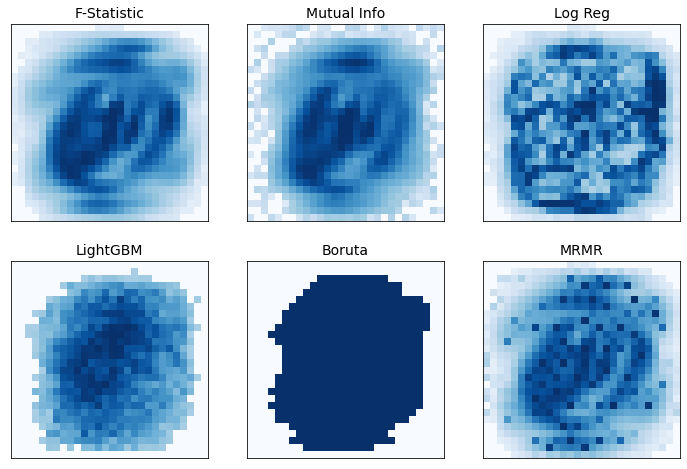

In [12]:
plt_ncols = 3
plt_nrows = 2

fig, axs = plt.subplots(plt_nrows, plt_ncols, figsize = (plt_ncols * 4, plt_nrows * 4))

for e, (algo, title) in enumerate(
    zip(
        ['f', 'mi', 'logreg', 'lightgbm', 'boruta', 'mrmr'],
        ['F-Statistic', 'Mutual Info', 'Log Reg', 'LightGBM', 'Boruta', 'MRMR']
    )):

    a = axs[divmod(e, plt_ncols)].imshow(
        ranking[algo].to_numpy().reshape(28, 28), 
        cmap = 'Blues_r', 
        vmin = ranking.min().min(), 
        vmax = ranking.max().max()
    )
    
    axs[divmod(e, plt_ncols)].set_title(title, fontsize = 14)
    axs[divmod(e, plt_ncols)].set_xticks([])
    axs[divmod(e, plt_ncols)].set_yticks([])
    
fig.savefig('featimpo_heatmap.png', dpi = 300)

# Predictive Performance on Top Features

In [13]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

algos = ['f', 'mi', 'logreg', 'lightgbm', 'mrmr']
ks = [1, 2, 5, 10, 15, 20, 30, 40]

accuracy = pd.DataFrame(index = ks, columns = algos)
roc = pd.DataFrame(index = ks, columns = algos)

for algo in algos:
    
    for k in ks:
    
        cols = ranking[algo].sort_values().head(k).index.to_list()
                
        clf = CatBoostClassifier().fit(
            X_train[:, cols], y_train,
            eval_set = (X_test[:, cols], y_test),
            early_stopping_rounds = 20,
            verbose = False
        )
                
        accuracy.loc[k, algo] = accuracy_score(
            y_true = y_test, y_pred = clf.predict(X_test[:, cols]))
        roc.loc[k, algo] = roc_auc_score(
            y_true = y_test, y_score = clf.predict_proba(X_test[:, cols]), multi_class = 'ovr', average = 'macro')
        
accuracy.to_csv('accuracy.csv', index = True)
roc.to_csv('roc.csv', index = True)

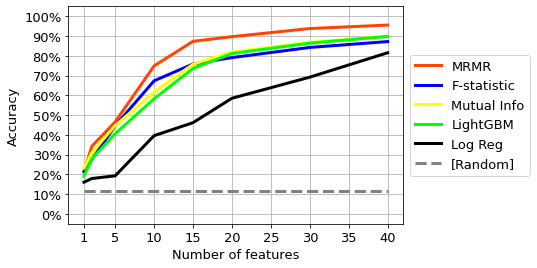

In [14]:
for algo, label, color in zip(
    ['mrmr', 'f', 'mi', 'lightgbm', 'logreg'],
    ['MRMR', 'F-statistic', 'Mutual Info', 'LightGBM', 'Log Reg'],
    ['orangered', 'blue', 'yellow', 'lime', 'black']):
        plt.plot(accuracy.index, accuracy[algo], label = label, color = color, lw = 3)

plt.plot(
    [1, 40], [pd.Series(y_test).value_counts(normalize = True).iloc[0]] * 2, 
    label = '[Random]', color = 'grey', ls = '--', lw = 3
)

plt.legend(fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid()
plt.yticks(np.linspace(0, 1, 11), ['{:.0%}'.format(i) for i in np.linspace(0, 1, 11)], fontsize = 13)
plt.xticks([1] + list(range(5, 41, 5)), fontsize = 13)
plt.xlim(-1, 42)
plt.ylim(-.05, 1.05)
plt.xlabel('Number of features', fontsize = 13)
plt.ylabel('Accuracy', fontsize = 13)
plt.savefig('accuracy.png', dpi = 300, bbox_inches = 'tight')

# Plot masked images

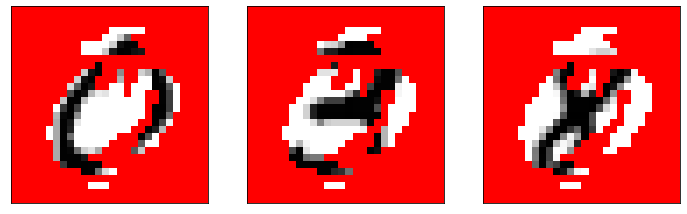

In [15]:
from matplotlib import cm

plt_ncols = 3
plt_nrows = 1

cmap = cm.get_cmap('binary')
cmap.set_bad(color = 'red')

fig, axs = plt.subplots(plt_nrows, plt_ncols, figsize = (plt_ncols * 4, plt_nrows * 4))

for e, i in enumerate([1, 7, 17]):
    
    axs[e].imshow(
        pd.DataFrame(X_train).iloc[i, :].mask(ranking['f'] > 200).to_numpy().reshape(28, 28), 
        cmap = cmap, vmin = 0, vmax = 255
    )
    
    #axs[divmod(e, plt_ncols)].set_title(title, fontsize = 14)
    axs[e].set_xticks([])
    axs[e].set_yticks([])
    
fig.savefig('digits_masked.png', dpi = 300)